# 0. Install and Import Libraries

install pip packages beautifulsoup4 in the current Jupyter kernel

In [85]:
import sys
!{sys.executable} -m pip install beautifulsoup4

import relevant libraries

In [139]:
import pandas as pd
import numpy as np
import networkx as nx
import math
import requests
import urllib.request
from bs4 import BeautifulSoup
import bleach
import re
import matplotlib.pyplot as plt
%matplotlib inline
from fa2 import ForceAtlas2
import pickle
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from community import community_louvain
import json
import pprint

define functions `printList` and `printDic` to print the first five elements in a list/dictionary

In [2]:
def printList(lst):
    count = 0
    for i in lst:
        print(i)
        count += 1
        if count == 5:
            break
    return 

def printDic(dic):
    count = 0
    for (k,v) in dic.items():
        print(k , v)
        count += 1
        if count == 5:
            break
    return

# 1. Data Extraction

In this section, we obtain data related to Game of Thrones from various sources.

## 1.1. Obtain Character Names and GOT Wiki Pages
This section involves two steps:
1. There are two tables listing main characters in the [Wikipedia page](https://en.wikipedia.org/wiki/List_of_Game_of_Thrones_characters). First, we read in the table and extract the character names. 

2. For each name obtained in step 1, scrape the Game of Thrones Wiki site to find the corresponding page of this character.

In [3]:
table1=pd.read_csv("table-1.csv")
table2=pd.read_csv("table-2.csv")

In [4]:
# table1 stores the main characters in the GOT series
table1.head()

Actor/Actress         Character Appearances Appearances.1  \
0          Actor/Actress         Character           1             2   
1           Sean Bean[a]      Eddard Stark        Main           NaN   
2              Mark Addy  Robert Baratheon        Main           NaN   
3  Nikolaj Coster-Waldau   Jaime Lannister        Main          Main   
4       Michelle Fairley     Catelyn Stark        Main          Main   

  Appearances.2 Appearances.3 Appearances.4 Appearances.5 Appearances.6  \
0             3             4             5             6             7   
1           NaN           NaN           NaN     Recurring         Guest   
2           NaN           NaN           NaN           NaN           NaN   
3          Main          Main          Main          Main          Main   
4          Main           NaN           NaN           NaN           NaN   

  Appearances.7  
0             8  
1           NaN  
2           NaN  
3          Main  
4           NaN

In [5]:
# table2 stores the recurring characters in the GOT series
table2.head()

Actor/Actress              Character Appearances Appearances.1  \
0      Actor/Actress              Character           1             2   
1      Julian Glover  Grand Maester Pycelle   Recurring     Recurring   
2        Ian Beattie            Meryn Trant   Recurring     Recurring   
3  Kristian Nairn[a]                  Hodor   Recurring     Recurring   
4       Mark Stanley                  Grenn   Recurring     Recurring   

  Appearances.2 Appearances.3 Appearances.4 Appearances.5 Appearances.6  \
0             3             4             5             6             7   
1     Recurring     Recurring     Recurring     Recurring           NaN   
2     Recurring     Recurring     Recurring           NaN           NaN   
3     Recurring     Recurring           NaN     Recurring           NaN   
4     Recurring     Recurring           NaN           NaN           NaN   

  Appearances.7  
0             8  
1           NaN  
2           NaN  
3           NaN  
4           NaN

In [6]:
# obtain the main characters and recurring characters lists
# join the two lists
list1=table1.Character.tolist()[1:]
list2=table2.Character.tolist()[1:]
list_full=list1 + list2

# print the first five elements in the list
printList(list_full)

Eddard Stark
Robert Baratheon
Jaime Lannister
Catelyn Stark
Cersei Lannister


We then use web scraping (with the help of `BeautifulSoup` library) to extract each character's information from the Game of Thrones Wiki

In [7]:
# define a funciton to extract the GOT Wiki page content of a character.

def getText():
    
    pages_dic={}
    
    for character in list_full:
    
        # parse url character name
        if " " in character:
            character = re.sub(r" ", "_", character)

        url="https://gameofthrones.fandom.com/wiki/" + character # get base url

        response = requests.get(url) # request a server response

        # not found
        if response.status_code == 404:
            print("{} wiki is not found.".format(character))
            continue

        soup = BeautifulSoup(response.text, "html.parser") # parse text from html

        para=soup.findAll('p') # find all paragraphs

        # clean the raw text
        res=[]
        for p in para:
            p = re.sub(r"<.+?>", "", str(p)) # remove all other tags e.g. <a href>
            p = re.sub(r"\[\d+?\]", " ", p)  # remove footnote label e.g. [1], [2]
            p = re.sub(r"\n", "", p)         # remove newline character
            p = re.sub(r"\xa0", u" ", p)     # remove empty space due to encoding

            if len(p) != 0 and p[-1] == " ": # remove empty space at the end, if present
                p = p[:-1]
            res.append(p)

        page = "".join(res)
        
        # store the character and his/her corresponding page to a dictionary
        pages_dic[character] = page
    
    # save the file as a pickle object
    pickle.dump(pages_dic, open('pages.p', 'wb'))
    
    return None

In [8]:
# only run once
# getText()

In [9]:
# load the pickled file
infile = open("pages.p",'rb')
pages = pickle.load(infile)
infile.close()

## 1.2. Obtain a Dictionary Storing Character Names and Their Variants
There are mismatches between the Wikipedia character names and the names used in GOT Wiki, as it is not uncommon for a character to have nicknames/aliases. We need to resolve this so as to build a more representative network. 
<br>
<br>
To achieve this, we search the Web and collect a list of all possible nicknames/aliases for each character. It is a slow and tedious process, but we cannot find a better workaround at this point. We then build a dictionary with key being a character's full name and value being his/her list of nicknames. 
<br>
<br>
Note that we will only consider nicknames of characters who are mentioned in [GOT Wiki] https://gameofthrones.fandom.com/wiki/Game_of_Thrones_Wiki).

In [10]:
# define a function to create a dictionary of aliases, as described above
def characterDic():
    
    nicknames = {}
    
    for name in pages.keys():
        parsed_name = name.replace("_", " ")
        nicknames[parsed_name] = [parsed_name,]
    
        # special cases --> not really literal names     
        if parsed_name in ["High Septon", "Black Walder Rivers", "Spice King",
                           "Night King", "Wun Weg Wun Dar Wun", "Lady Crane",
                           "Grey Worm", "Silk King","Little Sam","Hot Pie",
                           "Khal Drogo","Three-Eyed Raven","Black Lorren",
                           "Maester Luwin", "Maester Aemon","The Waif"]:
            continue
                  
        # general case --> extract the first name
        if " " in parsed_name:
            firstname = parsed_name.split(" ")[0]
            nicknames[parsed_name] += [firstname,]
    
    # Some manual editing to improve accuracy
    nicknames["Jon Snow"] += ["Aegon", "Lord Snow"]
    nicknames["Bran Stark"] += ["Three-Eyed Raven", "Brandon"]
    nicknames["Davos Seaworth"] += ["Onion Knight", "Davos"]
    nicknames["Jaime Lannister"] += ["Kingslayer"]
    nicknames["Tyrion Lannister"] += ["Imp", "Halfman", "Little Lion"]
    nicknames["Gregor Clegane"] += ["The Mountain",]
    nicknames["Joffrey Baratheon"] += ["Joff"]
    nicknames["Daenerys Targaryen"] += ["Daenerys Stormborn", "Stormborn", "Dany", 
                                       "Mhysa", "Dragon Queen", "Khaleesi"]
    nicknames["Varys"] += ["Spider", "Eunuch"]
    nicknames["Theon Greyjoy"] += ["Reek",]
    nicknames["Grey Worm"] += ["Torgo Nudho",]
    nicknames["Olenna Tyrell"] += ["Redwyne",]
    nicknames["Brienne of Tarth"] += ["Brienne", "Maid of Tarth"]
    nicknames["Samwell Tarly"] += ["Sam", "Piggy"]
    nicknames["Gendry Baratheon"] = ["Gendry", "Clovis"]
    nicknames["Petyr Baelish"] += ["Littlefinger", "Baelish"]
    nicknames["Sandor Clegane"] += ["Hound"]
    nicknames["Melisandre"] += ["Red Woman", "Red Witch"]
    
    return nicknames

In [11]:
characters = characterDic()
printDic(characters)

Eddard Stark ['Eddard Stark', 'Eddard']
Robert Baratheon ['Robert Baratheon', 'Robert']
Jaime Lannister ['Jaime Lannister', 'Jaime', 'Kingslayer']
Catelyn Stark ['Catelyn Stark', 'Catelyn']
Cersei Lannister ['Cersei Lannister', 'Cersei']


## 1.3. Find Wars, Houses and Their Stances from GOT Wiki

In [14]:
def WarLinks():
    url = "https://gameofthrones.fandom.com/wiki/Category:Wars"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    tags = soup.findAll("a", {"class" : "category-page__member-link"}, href=True)
    links=[]
    for a in tags:
        links.append(a['href'][6:])
        
    links=[link for link in links if ("Category" not in link) and ("User" not in link)]
    return links
wars = WarLinks()
printList(wars)

Andal_Invasion
Black_Friday
Blackfyre_Rebellion
Century_of_Blood
Conflict_beyond_the_Wall


In [50]:
def combatants(battle):
    patterns=["House\s.*?\w*", "White\sWalkers", "Night's\sWatch", 
              "Free\sFolk", "Brotherhood\sWithout\sBanners"]
    
    url = "https://gameofthrones.fandom.com/wiki/" + battle
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    # find all houses on side 1
    side1 = str(soup.findAll("td", 
                        {"class" : "pi-horizontal-group-item pi-data-value pi-font pi-border-color pi-item-spacing",
                        "data-source" : "side1"}))
    side1_list=[]
    for pat in patterns:
        side1_list.extend(re.findall(pat, side1))       
    side1_set=set(side1_list)
    
    # find all houses on side 2
    side2 = str(soup.findAll("td", 
                        {"class" : "pi-horizontal-group-item pi-data-value pi-font pi-border-color pi-item-spacing",
                        "data-source" : "side2"}))
    side2_list=[]
    for pat in patterns:
        side2_list.extend(re.findall(pat, side2))
        
    side2_set=set(side2_list)
    
    ally=[]
    for house_o in list(side1_set):
        for house_i in list(side1_set):
            if house_o == house_i:
                continue
            ally.append((house_o, house_i))
    
    for house_o in list(side2_set):
        for house_i in list(side2_set):
            if house_o == house_i:
                continue
            ally.append((house_o, house_i))
    
    enemy=[]
    for house_1 in list(side1_set):
        for house_2 in list(side2_set):
            if house_1 == house_2:
                continue
            enemy.append((house_1, house_2))

    
    return (ally, enemy)

In [51]:
def Ally_Enemy():
    ally={}
    enemy={}
    for war in wars:
        relationship = combatants(war)
        for tup in relationship[0]:
            if tup in ally:
                ally[tup] += 1
            elif (tup[1],tup[0]) in ally:
                ally[(tup[1],tup[0])] += 1
            else:
                ally[tup] = 1
        for tup in relationship[1]:
            if tup in enemy:
                enemy[tup] += 1
            elif (tup[1],tup[0]) in enemy:
                enemy[(tup[1],tup[0])] += 1
            else:
                enemy[tup] = 1
                
    # account for "House of" which is very rare, ignore to avoid over-counting
    ally = {key : int(val/2) for key, val in ally.items() if "House of" not in key}
    enemy = {key : val for key, val in enemy.items() if "House of" not in key}
    return (ally, enemy)

battleField=Ally_Enemy()
ally=battleField[0]
enemy=battleField[1]

In [16]:
def House():
    
    dics = Ally_Enemy()
    ally = [house for tup in list(dics[0].keys()) for house in tup]
    enemy = [house for tup in list(dics[1].keys()) for house in tup]
    return set(ally).union(set(enemy))

houses = House()

# 2. Network Analysis

In [63]:
# network of ally
# node is house name
# edge when two houses have fought together / against, edge weight is the number of times
def House_Network(NodeList, EdgeDictionary):
    G=nx.Graph()
    G.add_nodes_from(NodeList)
    G.add_edges_from([(k[0], k[1], {"weight": v})for k,v in EdgeDictionary.items()])
    return G

# Enemy

In [61]:
enemy_network=House_Network(houses, enemy)

In [131]:
# use positions from the forceatlas algorithm for better visualization of graphs
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.0001,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=False)

positions_enemy = forceatlas2.forceatlas2_networkx_layout(enemy_network, 
                                                    pos=None,iterations=1000)

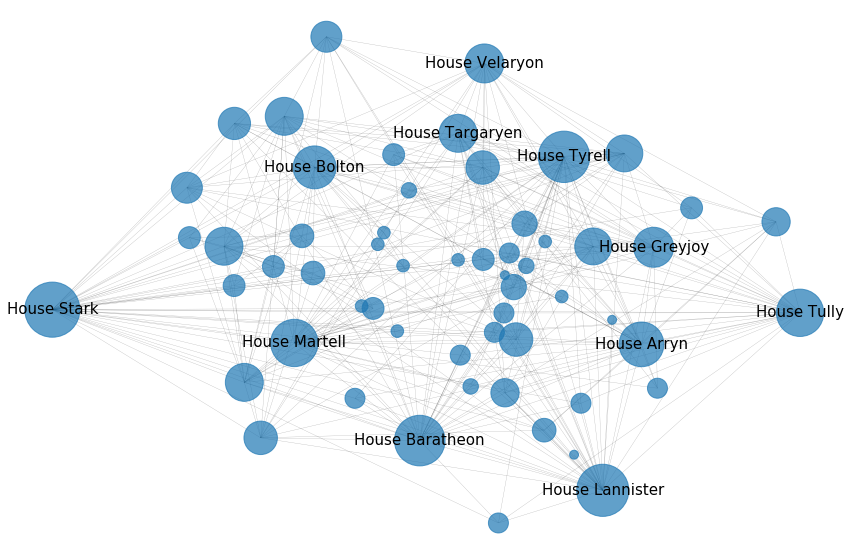

In [77]:
# Plot a network graph
labeling={}

for node in enemy_network.nodes:
    if enemy_network.degree(weight="weight")[node] > 25:
        labeling[node] = node

plt.figure(figsize=(15,10))
plt.axis("off")
nx.draw_networkx_edges(enemy_network, positions, width = 0.3, alpha = 0.3, arrows=False)
nx.draw_networkx_nodes(enemy_network, positions, alpha= 0.7, 
                       node_size=[enemy_network.degree[n] * 80 for n in enemy_network.nodes])
nx.draw_networkx_labels(enemy_network, positions, labels=labeling, font_size=15)

plt.show()

In [81]:
# Top N houses which fought most frequently
sorted([[node, enemy_network.degree(weight = "weight")[node]] for node in enemy_network],
      key=lambda x : x[1], reverse=True)[:5]

[['House Stark', 64],
 ['House Lannister', 64],
 ['House Tyrell', 57],
 ['House Baratheon', 50],
 ['House Martell', 46]]

In [82]:
# Top N houses which had the most number of enemies
sorted([[node, enemy_network.degree[node]] for node in enemy_network],
      key=lambda x : x[1], reverse=True)[:5]

[['House Stark', 38],
 ['House Lannister', 34],
 ['House Tyrell', 33],
 ['House Baratheon', 32],
 ['House Tully', 28]]

# Ally

In [83]:
ally_network=House_Network(houses, ally)

In [130]:
# use positions from the forceatlas algorithm for better visualization of graphs
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.0001,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=False)

positions_ally = forceatlas2.forceatlas2_networkx_layout(ally_network, 
                                                    pos=None,iterations=1000)

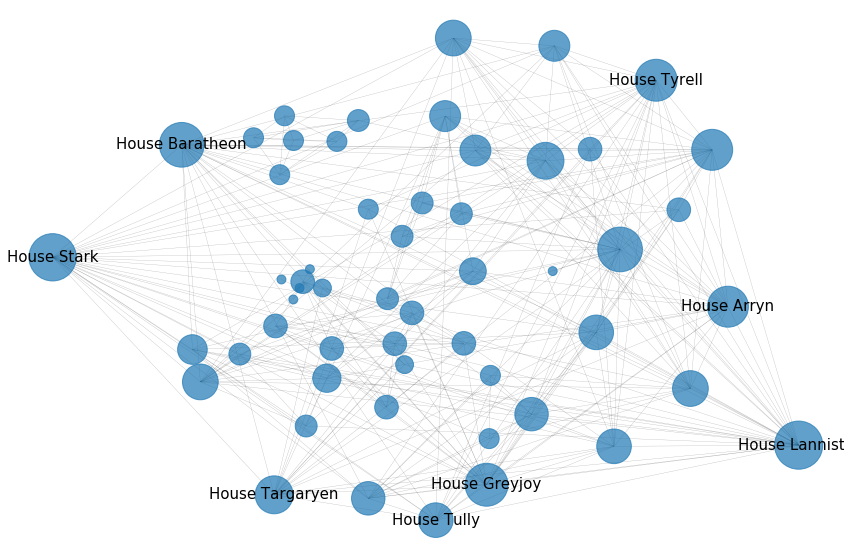

In [86]:
# Plot a network graph
labeling={}

for node in ally_network.nodes:
    if ally_network.degree(weight="weight")[node] > 30:
        labeling[node] = node

plt.figure(figsize=(15,10))
plt.axis("off")
nx.draw_networkx_edges(ally_network, positions, width = 0.3, alpha = 0.3, arrows=False)
nx.draw_networkx_nodes(ally_network, positions, alpha= 0.7, 
                       node_size=[ally_network.degree[n] * 80 for n in ally_network.nodes])
nx.draw_networkx_labels(ally_network, positions, labels=labeling, font_size=15)

plt.show()

In [87]:
# Top N houses which pledge alliance the most number of times
sorted([[node, ally_network.degree(weight = "weight")[node]] for node in ally_network],
      key=lambda x : x[1], reverse=True)[:5]

[['House Stark', 71],
 ['House Lannister', 61],
 ['House Baratheon', 57],
 ['House Tyrell', 47],
 ['House Targaryen', 46]]

In [88]:
# Top N houses which had the most number of allies
sorted([[node, ally_network.degree[node]] for node in ally_network],
      key=lambda x : x[1], reverse=True)[:5]

[['House Lannister', 29],
 ['House Stark', 28],
 ['House Baratheon', 25],
 ['House Bolton', 25],
 ['House Greyjoy', 23]]

# Community

In [162]:
def community(graph, pos):
    colors=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
        '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
        '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
        '#aaffc3', '#808000', '#ffd8b1']
    
    partition = community_louvain.best_partition(graph, 
                                                 weight = "weight", random_state = 13)
    modurality=community_louvain.modularity(partition, graph, weight='weight')
    print("modurality is {}".format(modurality))
    print("********************************************************")
    partition_values = list(partition.values())
    partition_keys = list(partition.keys())
    partition_items = list(partition.items())
    
    community_dic={}
    for house,com in partition_items:
        if com in community_dic:
            community_dic[com] += [house,]
        else:
            community_dic[com] = [house,]

    js=json.dumps(community_dic, indent=2, sort_keys=True)
    print("********************************************************")
    plt.figure(figsize=(12,8))
    plt.axis("off")

    count = 0
    for com in set(partition_values):
        list_nodes = [partition_keys[i] for i in range(len(partition_keys)) if partition_values[i] == com]
        nx.draw_networkx_nodes(graph, pos, nodelist=list_nodes, node_size = 80, 
                               node_color = colors[count], node_shape='o')
        count = count + 1

    nx.draw_networkx_edges(graph,pos, list(graph.edges), 
                           width=0.15, arrows=False, 
                           alpha=0.9, edge_color="dimgray")

    plt.show()
    return js
    
    

modurality is 0.18404601644089125
********************************************************
********************************************************


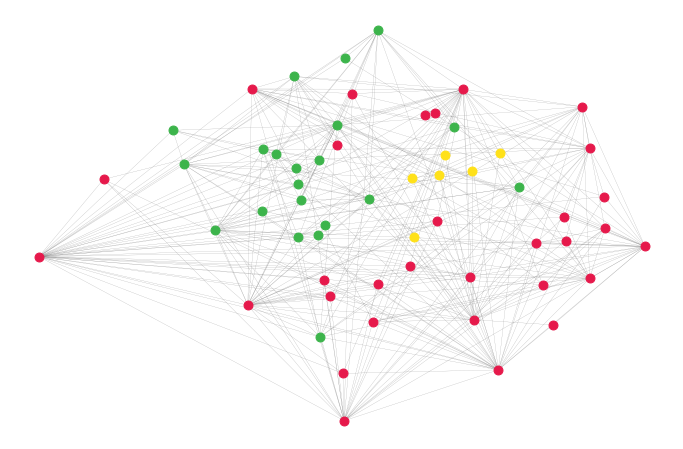

In [163]:
enemy_js=community(enemy_network,positions_enemy)

In [164]:
print(enemy_js)

{
  "0": [
    "House Royce",
    "House Botley",
    "House Tully",
    "House Stark",
    "House Targaryen",
    "House Merlyn",
    "House Greyiron",
    "House Goodbrother",
    "House Reyne",
    "House Sparr",
    "House Lannister",
    "House Drumm",
    "House Redwyne",
    "House Tyrell",
    "House Durrandon",
    "House Martell",
    "House Tarbeck",
    "House Baratheon",
    "House Qoherys",
    "House Hightower",
    "House Blackfyre",
    "House Hollard",
    "House Velaryon",
    "House Harlaw",
    "House Tarly",
    "House Mudd",
    "House Frey",
    "House Greyjoy",
    "House Arryn",
    "House Gardener",
    "House Blacktyde"
  ],
  "1": [
    "House Glenmore",
    "House Towers",
    "House Frost",
    "Brotherhood Without Banners",
    "White Walkers",
    "House Hoare",
    "House Amber",
    "House Florent",
    "House Umber",
    "Free Folk",
    "House Reed",
    "House Mazin",
    "House Forrester",
    "House Hornwood",
    "House Karstark",
    "House Mor

modurality is 0.2708724561097039
********************************************************
********************************************************


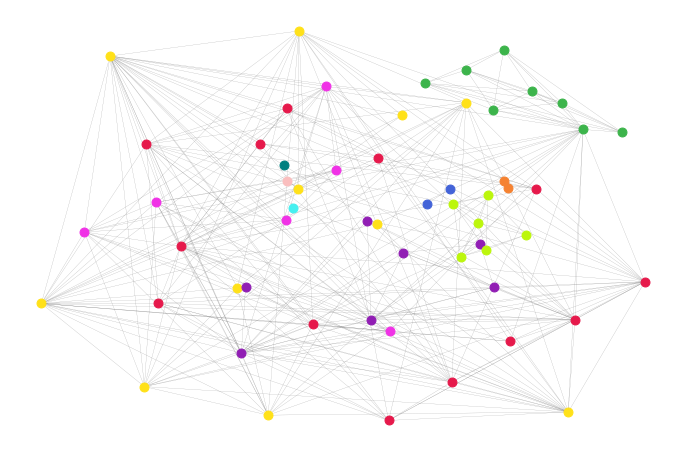

In [165]:
ally_js=community(ally_network,positions_ally)

In [166]:
print(ally_js)

{
  "0": [
    "House Royce",
    "House Stark",
    "House Greyiron",
    "Brotherhood Without Banners",
    "Free Folk",
    "House Durrandon",
    "House Mazin",
    "House Martell",
    "House Hornwood",
    "House Mudd",
    "House Arryn",
    "House Gardener",
    "Night's Watch"
  ],
  "1": [
    "House Botley",
    "House Merlyn",
    "House Goodbrother",
    "House Sparr",
    "House Drumm",
    "House Harlaw",
    "House Greyjoy",
    "House Blacktyde"
  ],
  "2": [
    "House Tully",
    "House Targaryen",
    "House Lannister",
    "House Redwyne",
    "House Tyrell",
    "House Baratheon",
    "House Qoherys",
    "House Hightower",
    "House Velaryon",
    "House Tarly",
    "House Frey"
  ],
  "3": [
    "House Reyne",
    "House Tarbeck"
  ],
  "4": [
    "House Glenmore",
    "House Forrester"
  ],
  "5": [
    "House Towers",
    "House Frost",
    "House Hoare",
    "House Amber",
    "House Whitehill",
    "House Bolton",
    "House Greenwood"
  ],
  "6": [
    "Wh

## 2.1. GOT Wiki
This section focuses on analysis of networks built from the previously scraped GOT Wiki pages

### 2.1.1. Build a network of main characters
* **Node**: character name
* **Edge**: their connection identified in wiki page

In [108]:
# define a function to calculate edge weights
# weight of a directed edge from A to B is defined as the number of times B is mentioned in A

def edgeWeight():
    
    # initialize a dictionary to store the edge weights
    # key = (A,B), value = N
    # In wiki page of A, B is mentioned N times
    res_dic={}
    
    # iterate through each character
    for ch in characters:
        
        # obtain all his/her names/alias
        alias=characters[ch]
        
        # iterate through every wikipage
        for name in pages:
                
            parsed_name = name.replace("_", " ")
            
            # obtain the text
            text=pages[name] 
            
            # prevent self loop --> Jon Snow page mentions Jon Snow himself N times
            if parsed_name != ch:
                for al in alias:
                    text=text.replace(al, ch)
                
                count=text.count(ch)
                    
                # update result dictionary
                if count != 0:
                    res_dic[(parsed_name, ch)]=count

    return res_dic

In [109]:
edgeWightDic=edgeWeight()
printDic(edgeWightDic)

('Robert Baratheon', 'Eddard Stark') 43
('Jaime Lannister', 'Eddard Stark') 26
('Catelyn Stark', 'Eddard Stark') 29
('Cersei Lannister', 'Eddard Stark') 30
('Daenerys Targaryen', 'Eddard Stark') 5


In [110]:
characters.keys()

dict_keys(['Eddard Stark', 'Robert Baratheon', 'Jaime Lannister', 'Catelyn Stark', 'Cersei Lannister', 'Daenerys Targaryen', 'Jorah Mormont', 'Viserys Targaryen', 'Jon Snow', 'Sansa Stark', 'Arya Stark', 'Robb Stark', 'Theon Greyjoy', 'Bran Stark', 'Joffrey Baratheon', 'Sandor Clegane', 'Tyrion Lannister', 'Khal Drogo', 'Petyr Baelish', 'Davos Seaworth', 'Samwell Tarly', 'Stannis Baratheon', 'Melisandre', 'Jeor Mormont', 'Bronn', 'Varys', 'Shae', 'Margaery Tyrell', 'Tywin Lannister', 'Talisa Maegyr', 'Ygritte', 'Gendry', 'Tormund Giantsbane', 'Brienne of Tarth', 'Ramsay Bolton', 'Gilly', 'Daario Naharis', 'Missandei', 'Ellaria Sand', 'Tommen Baratheon', "Jaqen H'ghar", 'Roose Bolton', 'Grey Worm', 'Meryn Trant', 'Hodor', 'Grenn', 'Osha', 'Rickon Stark', 'Ros', 'Gregor Clegane', 'Janos Slynt', 'Lancel Lannister', 'Myrcella Baratheon', 'Rodrik Cassel', 'Maester Luwin', 'Irri', 'Doreah', 'Renly Baratheon', 'Yoren', 'Kevan Lannister', 'Rakharo', 'Ilyn Payne', 'Barristan Selmy', 'Rast', 'Ma

In [111]:
# define a function to classify each character into his/her respective houses
# add house and color as node attributes

def Nodes():
    Nodes_Dic={}
    for ch in characters:
        try:
            last_name = ch.split(" ")[1]
        except:
            last_name = ""
            
        # shoud I put Stark or Targaryen?
        # L + R = J :)
        if ch == "Jon Snow":
            Nodes_Dic[ch] = {"House" : "Stark", "Color": "#a9a9a9"} # Stark is Grey
            
        elif last_name == "Stark":
            Nodes_Dic[ch] = {"House" : "Stark", "Color": "#a9a9a9"}
        
        # For joffrey, Tommen and Myrcella, should I put Baratheon or Lannister?
        # My uncle is my father :O
        elif last_name == "Baratheon":
            Nodes_Dic[ch] = {"House" : "Baratheon", "Color" : "#000000"} # Baratheon is Black
            
        elif last_name == "Lannister":
            Nodes_Dic[ch] = {"House" : "Lannister", "Color" : "#d4af37"} # Lannister is Gold
            
        elif last_name == "Targaryen":
            Nodes_Dic[ch] = {"House" : "Targaryen", "Color" : "#ff0000"} # Targaryen is Red
            
        else:
            Nodes_Dic[ch] = {"House" : "Unclassified", "Color": "#add8e6"} # Sorry but they are less important
    
    return Nodes_Dic

In [112]:
nodes = Nodes()

In [113]:
# build a directed graph with the appropriate edge weights
G=nx.DiGraph()
G.add_nodes_from(list(nodes.items()))
G.add_edges_from([(k[0],k[1],{"weight" : v}) for (k,v) in edgeWightDic.items()])

In [114]:
# use positions from the forceatlas algorithm for better visualization of graphs
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.0001,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=False)

positions = forceatlas2.forceatlas2_networkx_layout(G.to_undirected(), 
                                                    pos=None,iterations=10000)

//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


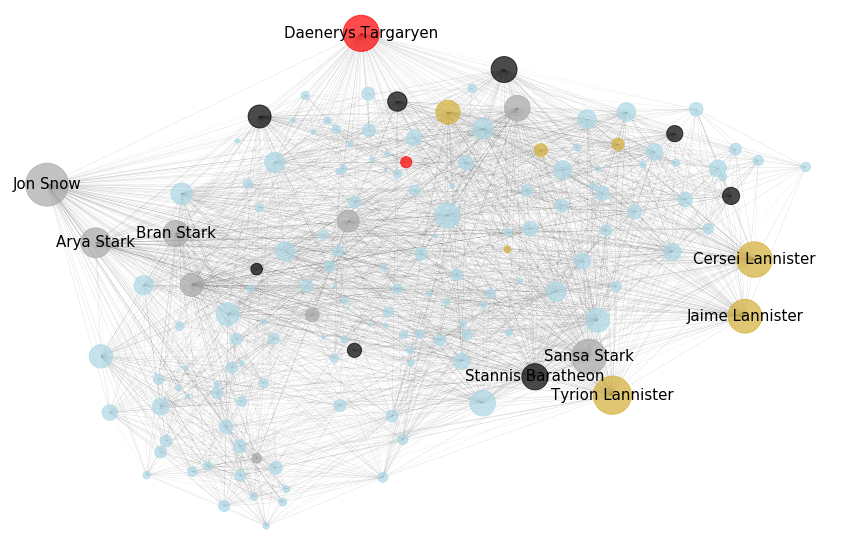

In [62]:
# Label list
labeling={}

for node in G.nodes:
    if G.degree(weight="weight")[node] > 1500:
        labeling[node] = node
        
# Node size list     
nodeSize = [G.degree(weight="weight")[character] for character in G.nodes] 

# Color list
colorList = [G.node[ch]["Color"] for ch in G.nodes]

# Plot a network graph
plt.figure(figsize=(15,10))
plt.axis("off")
nx.draw_networkx_edges(G, positions, width = 0.1, alpha = 0.3, arrows=False)
nx.draw_networkx_nodes(G, positions,alpha= 0.7, node_color = colorList,
                       node_size=[size/sum(nodeSize) * 100000/3 for size in nodeSize])
nx.draw_networkx_labels(G, positions, labels=labeling, font_size=15)

plt.show()

Some helper function before giving our awards.

In [17]:
# get color list --> different colors for top 3 characters

def getColorList(champion, first_runner_up, second_runner_up):
    colorList=[]
    for node in G.nodes:
        if node == champion:
            colorList.append("#ffd700") # gold
        elif node == first_runner_up:
            colorList.append("#aaa9ad") # silver
        elif node == second_runner_up:
            colorList.append("#cd7f32") # bronze
        else:
            colorList.append("#add8e6")
    return colorList

In [18]:
# get label list --> label for top N charaters

def getLabeling(sortedList, topN):
    labeling={}
    for node in G.nodes:
        if node in list(map(lambda x : x[0], sortedList[:topN])):
            labeling[node] = node
    return labeling

In [19]:
# general plot function

def plot(sizes,colors, labeling, adjustFactor): # adjustFactor to control node size
    plt.figure(figsize=(15,10))
    plt.axis("off")
    nx.draw_networkx_edges(G, positions, width = 0.1, alpha = 0.3, arrows=False)
    nx.draw_networkx_nodes(G, positions,alpha= 0.7, node_color=colors,
                           node_size=[size * adjustFactor for size in sizes])
    nx.draw_networkx_labels(G, positions, labels=labeling, font_size=12)
    plt.show()
    return 

> ## Most Mentioned Award

Who is mentioned the most number of times in others' wiki page?

In [20]:
sorting=sorted(list(G.in_degree(weight="weight")), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 2881), ('Daenerys Targaryen', 2030), ('Tyrion Lannister', 1990)]

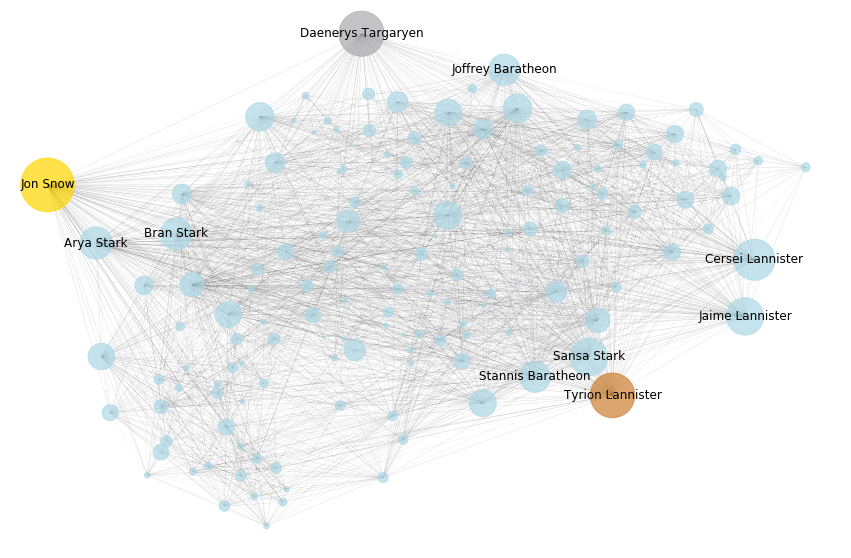

In [21]:
plot([G.in_degree(weight="weight")[character] for character in G.nodes],
     getColorList('Jon Snow','Daenerys Targaryen','Tyrion Lannister'),
     getLabeling(sorting, 10),1)

## The most mentioned award goes to........Jon Snow!

> ## Most Social Award

Whose page mentioned the most number of other characters?

In [22]:
sorting=sorted(list(G.out_degree(weight="weight")), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Sansa Stark', 1270), ('Tyrion Lannister', 1243), ('Jon Snow', 1183)]

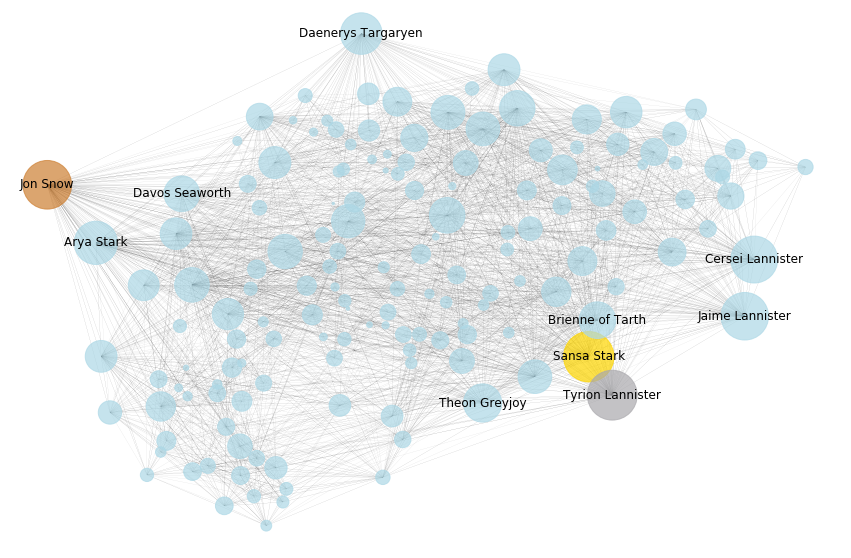

In [23]:
plot([G.out_degree(weight="weight")[character] for character in G.nodes],
     getColorList('Sansa Stark','Tyrion Lannister', 'Jon Snow'),
     getLabeling(sorting, 10), 2)

## The most social award goes to........Sansa Stark!

> ## Most "Reachable" Award

Who is on average closest other characters, starting from all the other nodes?

In [24]:
sorting=sorted(list(nx.closeness_centrality(G).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 0.7677095631641087),
 ('Tyrion Lannister', 0.6909386068476978),
 ('Cersei Lannister', 0.6816434686389844)]

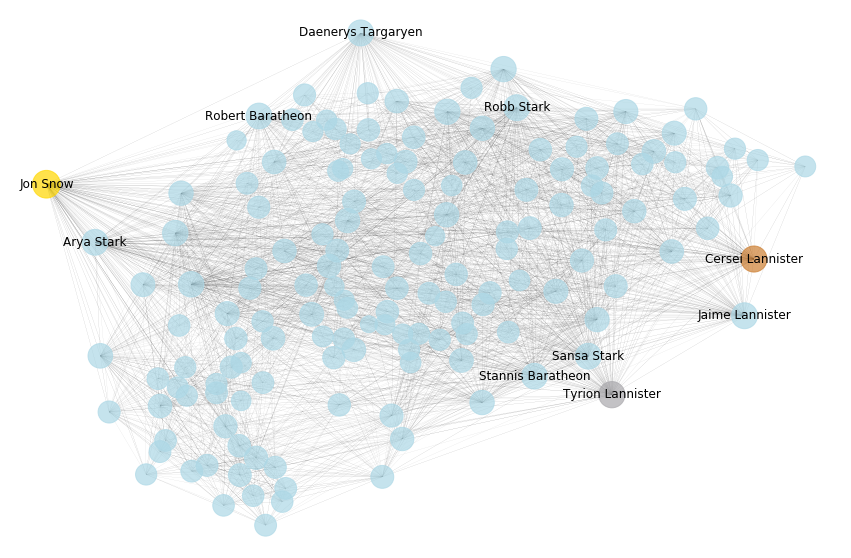

In [25]:
plot(list(nx.closeness_centrality(G).values()),
     getColorList('Jon Snow','Tyrion Lannister','Cersei Lannister'),
     getLabeling(sorting, 10), 1000)

## The most "reachable" award goes to........Jon Snow!

> ## The Delivery-Man Award

Who is on average closest other characters, starting from the node to other nodes? i.e. If I want to deliver pizza to every character. One character is chosen to be the starting point. Who will be the chosen character such that the time taken to spread message is minimized?

In [26]:
sorting=sorted(list(nx.closeness_centrality(G.reverse()).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 0.6609073745637623),
 ('Tyrion Lannister', 0.627723740694452),
 ('Jaime Lannister', 0.6225144150455354)]

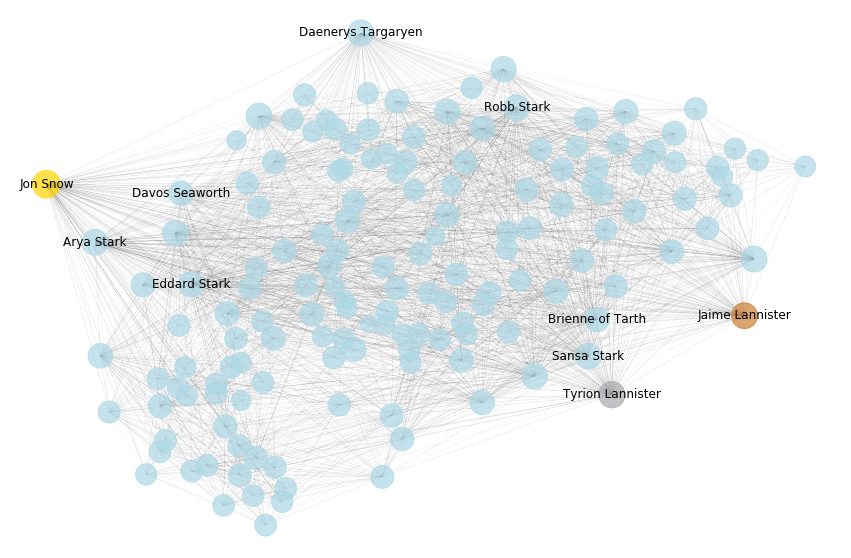

In [27]:
plot(list(nx.closeness_centrality(G).values()),
     getColorList('Jon Snow','Tyrion Lannister','Jaime Lannister'),
     getLabeling(sorting, 10), 1000)

## The Delivery-Man award goes to........Jon Snow!

> ## Most Critical Award 

Who appears the most number of times in the shortest path between any other two nodes?

In [28]:
sorting=sorted(list(nx.betweenness_centrality(G.reverse()).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 0.10258812592928719),
 ('Daenerys Targaryen', 0.08495488238473345),
 ('Arya Stark', 0.07439741540442442)]

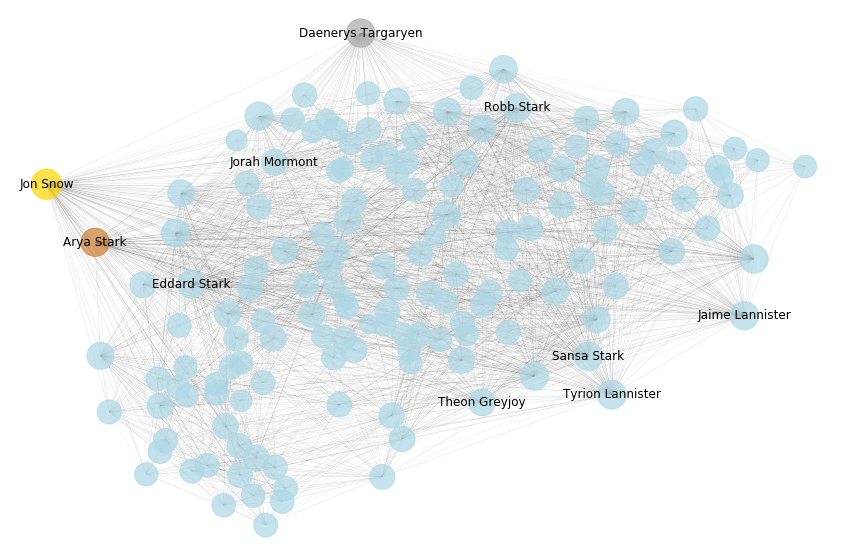

In [29]:
plot(list(nx.closeness_centrality(G).values()),
     getColorList('Jon Snow','Daenerys Targaryen','Arya Stark'),
     getLabeling(sorting, 10), 1200)

## The most critical award goes to........Jon Snow!

> ## Person with the most powerful connections

Who has the most powerful people as his connections? i.e. good if friends, bad if enemies!

In [30]:
sorting=sorted(list(nx.eigenvector_centrality(G).items()), key=lambda x : x[1], reverse=True)
top3=sorting[:3]
top3

[('Jon Snow', 0.20908603915428334),
 ('Cersei Lannister', 0.19097230878131516),
 ('Tyrion Lannister', 0.19014705946358837)]

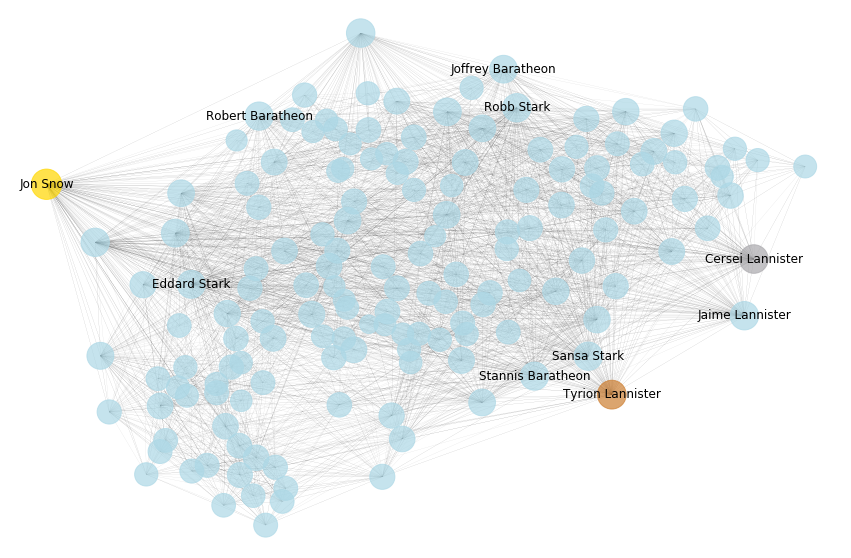

In [31]:
plot(list(nx.closeness_centrality(G).values()),
     getColorList('Jon Snow','Cersei Lannister','Tyrion Lannister'),
     getLabeling(sorting, 10), 1200)

## The award goes to........Jon Snow!

# Word Cloud && TF-IDF

In [32]:
def getNames():
    lst=[]
    for (k,v) in characters.items():
        lst.append(k.lower())
        lst.extend([vi.lower() for vi in v])
    return lst
nameList=getNames()

In [81]:
def keyWords(character, topN, excludeNames=False):
    page=pages[character].lower()
    
    if excludeNames:
        for name in nameList:
            page = page.replace(name, "")
    
    sentences=page.split(".")
    
    # init a count vector
    count_vector=CountVectorizer(max_df=0.9,stop_words="english")

    # create a word count for sentences
    word_count_vector=count_vector.fit_transform(sentences)
    
    # init a tfidf transformer
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    
    # fit with the word count vector
    tfidf_transformer.fit(word_count_vector)
    
    # sub our interested doc into the transformer
    tf_idf_vector=tfidf_transformer.transform(count_vector.transform([page]))
    
    # get the key words
    feature_names=count_vector.get_feature_names()
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    keywords=extract_topn_from_vector(feature_names,sorted_items,topN)
    
    return keywords

In [82]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn):
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a dictionary of feature,score
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [83]:
keyWords('Cersei_Lannister', 3, True)

{'king': 0.2, 'tells': 0.169, 'children': 0.131}

In [ ]:
def wordCloud(character, number_words=100, excludeName=False):
    plt.figure(figsize=(12,6))
    word_cloud = WordCloud(background_color="white", width=1500, height=800, 
                        max_words = number_words, colormap = 'Blues')
    word_cloud.generate_from_frequencies(
        keyWords(character, number_words, excludeName))

    plt.imshow(word_cloud, interpolation="bilinear")
    plt.title("{} WordCloud".format(character.replace("_", " ")), y=1.05)
    plt.axis("off")
    plt.show()
    return

In [ ]:
wordCloud("Jon_Snow", 50, excludeName=True)